[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/blob/main/01_BOW_sklearn_FFN.ipynb)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge
import os
import requests

### Data and Task Description

* in all notebooks we'll use the public datast *10kGNAD* (10k German News Articles Dataset), for more infos see https://tblock.github.io/10kGNAD/
* 10k **German News Articles** classified into **9 labels** (Topics/Rubrics)
    * Panorama, Web, International, Wirtschaft, Sport, Inland, Etat, Wissenschaft, Kultur 
* already split into train and test set
    * keep in mind, normally we want to have 3 splits (called train, dev/val, test), here we will use the so called test split more like you would use a development/validation split)
* so - not very surprising - we will do the task of supervised **text classification**
* note: this is a very simple NLP task, you absolutely don't need DL/BERT to solve it well, but for learning purposes it's good
* the _real_ benefit of DL-Models and BERT and friends is much more apparent in complex tasks, such as question answering, translation, sequence labelling, text generation, chatbots, summarization, ...


### Download data and create Dataframes

In [ ]:
os.makedirs('10kGNAD', exist_ok=True) # create folder in Colab

In [ ]:
# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [ ]:
!head 10kGNAD/train.csv

Sport;21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.
Kultur;'Erfundene Bilder zu Filmen, die als verloren gelten: "The Forbidden Room" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regi

In [ ]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])

In [ ]:
df_train.head()

,label,article
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [ ]:
print(df_train.shape, df_test.shape)

(9245, 2) (1028, 2)


In [ ]:
df_train.label.value_counts()

Panorama         1510
Web              1509
International    1360
Wirtschaft       1270
Sport            1081
Inland            913
Etat              601
Wissenschaft      516
Kultur            485
Name: label, dtype: int64

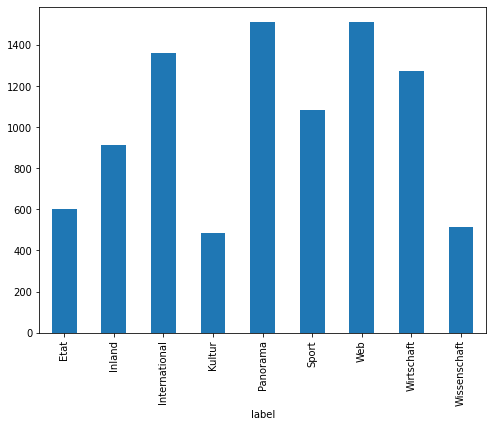

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_train.groupby('label').article.count().plot.bar(ylim=0)
plt.show()

### Transform labels to integers, make sure to keep mapping for later

In [ ]:
# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}


In [ ]:
# add columns with label_id
df_train["label_id"] = le.transform(df_train.label)
df_test["label_id"] = le.transform(df_test.label)

In [ ]:
# get label_names (in same order, used for classification reports)
label_names = list(le.classes_)
label_names

['Etat',
 'Inland',
 'International',
 'Kultur',
 'Panorama',
 'Sport',
 'Web',
 'Wirtschaft',
 'Wissenschaft']

In [ ]:
# see if everything looks good
df_train.head(10)

,label,article,label_id
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,5
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",3
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,6
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",7
4,Inland,Estland sieht den künftigen österreichischen P...,1
5,Wirtschaft,Der Welser Stempelhersteller verbreitert sich ...,7
6,Sport,Traditionsklub setzt sich gegen den FC Utrecht...,5
7,Etat,Finanzausschuss tagte Montag: Konfliktthemen S...,0
8,International,Militär setzt Offensive an Grenze zu Afghanist...,2
9,Sport,Abschiedstournee für Guardiola beginnt beim HS...,5


## BOW-Features

* Bag-of-Words: representing text with their token/n-gram counts
* n-grams: groups of tokens ("Vereinigte Staaten", "mehr oder weniger")
* no knowlegde of sequence/order of text, the relationship between tokens or their _meaning_
* still works well in some simple tasks
* most of the work is done by the CountVecotrizer from sklearn
* you should think abput preprocessing steps

In [ ]:
MAX_FEATURES = 2000
vectorizer = CountVectorizer(analyzer='word',
                             ngram_range= (1, 2),
                             max_features = MAX_FEATURES
                             )

In [ ]:
# train vectorizer on train texts and transform both train and test
X_train = vectorizer.fit_transform(df_train.article).toarray()           # only fit on train!
X_test = vectorizer.transform(df_test.article).toarray()                 # keep in mind: if you want to transform NEW text you need the vectorizer configurations

In [ ]:
print(X_train.shape, X_test.shape)

(9245, 2000) (1028, 2000)


In [ ]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [ ]:
#vectorizer.vocabulary_ # vocabulary of tokenizer: dict mapping tokens (n-grams) to their ids

In [ ]:
# labels (also known as target, gold)
y_train = df_train.label_id.values
y_test = df_test.label_id.values
print(y_train.shape, y_test.shape)

(9245,) (1028,)


### First: Try some simple models from scikit-learn

(Here we don't put effort in, of course this could/should be done more carefully...)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report

In [ ]:
model_dict = {'LinearSVC': LinearSVC(max_iter = 1000),
              'MultinomialNB': MultinomialNB(),
              'KNN': KNeighborsClassifier(5),
              'LogisticRegression': LogisticRegression(max_iter = 1000),
             }

for name, model in model_dict.items():
    print(name)
    model = model
    
    model.fit(X_train, y_train)

    # accuracy on test set
    accuracy = model.score(X_test, y_test)
    print("Accuracy:", accuracy)

    pred_test = model.predict(X_test)
    print(classification_report(y_test, pred_test, target_names=label_names))
    print("\n-------------------------------------------")

LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.7178988326848249
               precision    recall  f1-score   support

         Etat       0.67      0.64      0.66        67
       Inland       0.66      0.71      0.68       102
International       0.79      0.73      0.76       151
       Kultur       0.62      0.61      0.62        54
     Panorama       0.60      0.67      0.63       168
        Sport       0.91      0.89      0.90       120
          Web       0.81      0.82      0.81       168
   Wirtschaft       0.64      0.60      0.62       141
 Wissenschaft       0.71      0.70      0.71        57

     accuracy                           0.72      1028
    macro avg       0.71      0.71      0.71      1028
 weighted avg       0.72      0.72      0.72      1028


-------------------------------------------
MultinomialNB
Accuracy: 0.7558365758754864
               precision    recall  f1-score   support

         Etat       0.76      0.48      0.59        67
       Inland       0.74      0.80      0.77       102

### Now: FFN classifier, still with BOW features

* we'll keep Keras for now, for BERT (other notebook) we switch to PyTorch
* input: BOW-vector
* output: logits/probabilities for the 9 classes/labels
* hidden layer(s), maybe try Dropout

In [ ]:
# make labels into matrix --> only necessary if we want to use categorical_crossentropy, not when using sparse_categorical_crossentropy
from tensorflow.keras.utils import to_categorical
y_train_matrix = to_categorical(y_train, dtype ="int")
y_test_matrix = to_categorical(y_test, dtype ="int")

In [ ]:
y_train_matrix[:2] # "Sport" or 5, "Kultur" or 3

array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [ ]:
y_train[:2]

array([5, 3])

In [ ]:
# just an overview
print(X_train.shape, y_train.shape, y_train_matrix.shape)
print(X_test.shape, y_test.shape, y_test_matrix.shape)

(9245, 2000) (9245,) (9245, 9)
(1028, 2000) (1028,) (1028, 9)


In [ ]:
from tensorflow.keras import models, layers, optimizers, losses

ffn = models.Sequential()
ffn.add(layers.InputLayer(input_shape=(MAX_FEATURES,))) # BOW has shape MAX_FEATURES
#ffn.add(layers.Dropout(.2))
ffn.add(layers.Dense(64, activation="sigmoid"))
#ffn.add(layers.Dense(32, activation="sigmoid"))
ffn.add(layers.Dense(9, activation="softmax")) # nr of labels

In [ ]:
ffn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                128064    
                                                                 
 dense_5 (Dense)             (None, 9)                 585       
                                                                 
Total params: 128,649
Trainable params: 128,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ffn.compile(optimizers.Adam(learning_rate=0.0005),
            #optimizer = optimizers.SGD(learning_rate=0.01),
            #loss='categorical_crossentropy',                         # need to use y_train_matrix and y_test_matrix
            loss='sparse_categorical_crossentropy',                   # can use y_train and y_test
            metrics=['accuracy']
            )

In [ ]:
# when using sparse_categorical_crossentropy:
history = ffn.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1,
                  validation_data=(X_test, y_test)
                  )

# when using categorical_crossentropy:
#history = fnn.fit(X_train, y_train_matrix, epochs=15, batch_size=32, verbose=1,
#                  validation_data=(X_test, y_test_matrix)
#                  )

Epoch 1/15
289/289 [==============================] - 2s 5ms/step - loss: 1.5434 - accuracy: 0.5290 - val_loss: 1.1029 - val_accuracy: 0.7062
Epoch 2/15
289/289 [==============================] - 1s 4ms/step - loss: 0.9751 - accuracy: 0.7395 - val_loss: 0.8495 - val_accuracy: 0.7675
Epoch 3/15
289/289 [==============================] - 1s 4ms/step - loss: 0.7820 - accuracy: 0.7785 - val_loss: 0.7364 - val_accuracy: 0.7918
Epoch 4/15
289/289 [==============================] - 1s 4ms/step - loss: 0.6542 - accuracy: 0.8134 - val_loss: 0.6710 - val_accuracy: 0.7996
Epoch 5/15
289/289 [==============================] - 1s 4ms/step - loss: 0.5802 - accuracy: 0.8303 - val_loss: 0.6330 - val_accuracy: 0.8006
Epoch 6/15
289/289 [==============================] - 1s 4ms/step - loss: 0.5204 - accuracy: 0.8459 - val_loss: 0.6072 - val_accuracy: 0.8103
Epoch 7/15
289/289 [==============================] - 1s 4ms/step - loss: 0.4695 - accuracy: 0.8606 - val_loss: 0.5969 - val_accuracy: 0.8113
Epoch 

In [ ]:
loss, acc = ffn.evaluate(X_test, y_test)
#loss, acc = ffn.evaluate(X_test, y_test_matrix)

print(f"\nloss: {loss} \n acc: {acc}")

33/33 [==============================] - 0s 3ms/step - loss: 0.6013 - accuracy: 0.7986

loss: 0.601313054561615 
 acc: 0.798638105392456


In [ ]:
pred_test_prob = ffn.predict(X_test)
print(pred_test_prob[0])
pred_test =np.argmax(pred_test_prob,axis=1) # get the label prediction from the logits
print(pred_test[0])
print("\n----")
print(classification_report(y_test, pred_test, target_names=label_names))

[1.2530186e-04 1.2960818e-02 2.0038844e-03 1.9775084e-03 3.2691183e-03
 2.9550769e-04 7.0077442e-03 6.2432896e-02 9.0992719e-01]
8

----
               precision    recall  f1-score   support

         Etat       0.78      0.60      0.68        67
       Inland       0.75      0.80      0.77       102
International       0.79      0.81      0.80       151
       Kultur       0.79      0.78      0.79        54
     Panorama       0.74      0.71      0.73       168
        Sport       0.97      0.95      0.96       120
          Web       0.83      0.89      0.86       168
   Wirtschaft       0.73      0.77      0.75       141
 Wissenschaft       0.85      0.77      0.81        57

     accuracy                           0.80      1028
    macro avg       0.80      0.79      0.79      1028
 weighted avg       0.80      0.80      0.80      1028



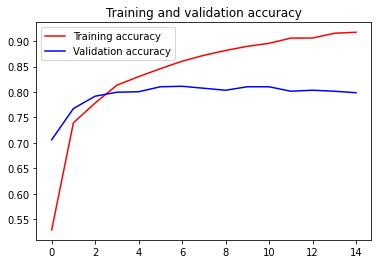

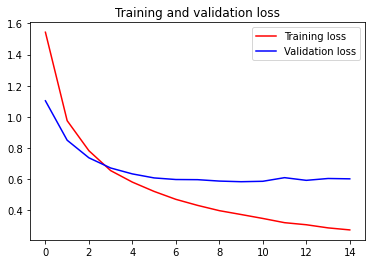

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

### Predicting new text

* feel free to be creative and add your own masterpiece of an article
* we will use these for all models
* keep in mind: we always need the same preprocessing/feature extraction steps as in training
    * here: BOW (with the _same_ CpountVectorizer)

In [ ]:
new_texts = [
             """Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen 
             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.""",
             
             """Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, 
             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.
             """,
             
             """Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der 
             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal
             """,
             
             """Abgesehen von pandemiegeschuldeter Einlasskontrolle und Maskenpflicht war es wie früher: das Freiburger Konzerthaus – ausverkauft! Kein Wunder, wenn die aus Südbaden stammende Weltklasse-Geigerin 
             Anne-Sophie Mutter und ihre seit nunmehr zehn Jahren bestehenden Mutter’s Virtuosi auftreten. Mittelpunkt und Rahmen jetzt: Antonio Vivaldi.
             """,
             
             """Ja, es ist ein Jugendstück. Anton Tschechow war 18 Jahre alt, als er es schrieb - und wieder vernichtete, nachdem es kein Gehör gefunden hatte. 
             Die Erstschrift hat sich erhalten und wurde 1920 unter dem – nicht von Tschechow stammenden – Titel "Platonow" veröffentlicht. Eine Jugendsünde ist es nicht, 
             denn viele Motive aus dem späteren Werk klingen an. Nur: Wenn man es vom Blatt spielte, dauerte die Aufführung geschlagene sechs Stunden, länger als jede Wagner-Oper. 
             """,

             #
             # add your own!
             #
             
]


In [ ]:
X_vectorized = vectorizer.transform(new_texts)

In [ ]:
probs = ffn.predict(X_vectorized)
print(probs) # what the model outputs
print("----")

labels = np.argmax(probs,axis=1) # get real labels from it
print(labels)
print("----")

print( [ (l, id_to_label[l]) for l in labels]) # get label names from label_id

# seems okay, but not perfect ("Web" for the first one is kind of far fetched...?)

[[0.1232974  0.03844244 0.06443235 0.1692898  0.1031383  0.04656199
  0.31135982 0.07403322 0.06944471]
 [0.03706698 0.09105882 0.25840768 0.02604546 0.20013201 0.18490267
  0.06808435 0.10821375 0.0260883 ]
 [0.02905877 0.02516407 0.03198356 0.10130268 0.02724876 0.6860939
  0.05420048 0.01216748 0.03278024]
 [0.18509369 0.07115185 0.06432089 0.1570101  0.15203524 0.05199018
  0.09506346 0.16739346 0.05594107]
 [0.0906005  0.04161699 0.05141032 0.4001838  0.0643043  0.08878489
  0.15143897 0.0512959  0.06036435]]
----
[6 2 5 0 3]
----
[(6, 'Web'), (2, 'International'), (5, 'Sport'), (0, 'Etat'), (3, 'Kultur')]


#### Out of curiosity: Predicting new texts with Logistic Regression

(Model should still be in memory known as `model`)

In [ ]:
LR_labels = model.predict(X_vectorized)
print(LR_labels)

print( [ (l, id_to_label[l]) for l in LR_labels]) # get label names from label_id


[6 2 5 7 3]
[(6, 'Web'), (2, 'International'), (5, 'Sport'), (7, 'Wirtschaft'), (3, 'Kultur')]
